In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

sys.path.append('../src')
from recommenders.item_based_rs import ItemBasedRecommenderSystem
from recommenders.user_based_rs import UserBasedRecommenderSystem
from recommenders.item_regression1 import ItemBasedRegressionRecommenderSystem1
from recommenders.item_regression2 import ItemBasedRegressionRecommenderSystem2
from recommenders.non_personalized_rs import NonPersonalizedRecommenderSystem
from utils.similarity_measure import pure_cosine_similarity, pearson_correlation
from utils.data_splitter import get_data

# Experiments

In [5]:
def evaluate_recommender_system(recommender_system, neighborhood_sizes, similarity_measure, x, model_size=100):
    mae_for_each_neighborhood_size = []

    train_df, test_df = get_data(data_path='../data/u.data', train_size=x, random_state=42)
    if recommender_system == "item_based":
        rs = ItemBasedRecommenderSystem(train_df, model_size, similarity_measure)
    elif recommender_system == "user_based":
        rs = UserBasedRecommenderSystem(train_df, model_size, similarity_measure)
    elif recommender_system == "item_regression":
        rs = ItemBasedRegressionRecommenderSystem1(train_df, model_size, similarity_measure)
    elif recommender_system == "non_personalized":
        rs = NonPersonalizedRecommenderSystem(train_df)

    rs.fit()
    mae_for_each_neighborhood_size = [rs.evaluate(test_df, neighborhood_size=neighborhood_size) for neighborhood_size in neighborhood_sizes]
    for i in range(len(neighborhood_sizes)):
        print(f"Recommendation system: {recommender_system}, similarity measure: {similarity_measure}, neighborhood size: {neighborhood_sizes[i]}, MAE: {mae_for_each_neighborhood_size[i]}")
    return mae_for_each_neighborhood_size

In [6]:
evaluate_recommender_system("non_personalized", [30], 'pure_cosine', x=0.9)

Recommendation system: non_personalized, similarity measure: pure_cosine, neighborhood size: 30, MAE: 0.8078477529660025


[0.8078477529660025]

## 1. Effect of Similarity Algorithm

In [7]:
results_df = pd.read_csv('../experiment_results.csv')
results_df.head()

,model,neighborhood_size,x,similarity_function,MAE
0,item_based,30,0.8,pure_cosine,0.818646
1,item_based,30,0.8,corr,0.898281
2,item_based,30,0.9,pure_cosine,0.815782
3,item_based,30,0.8,adjusted_cosine,NaN
4,item_based,10,0.8,pure_cosine,0.862526


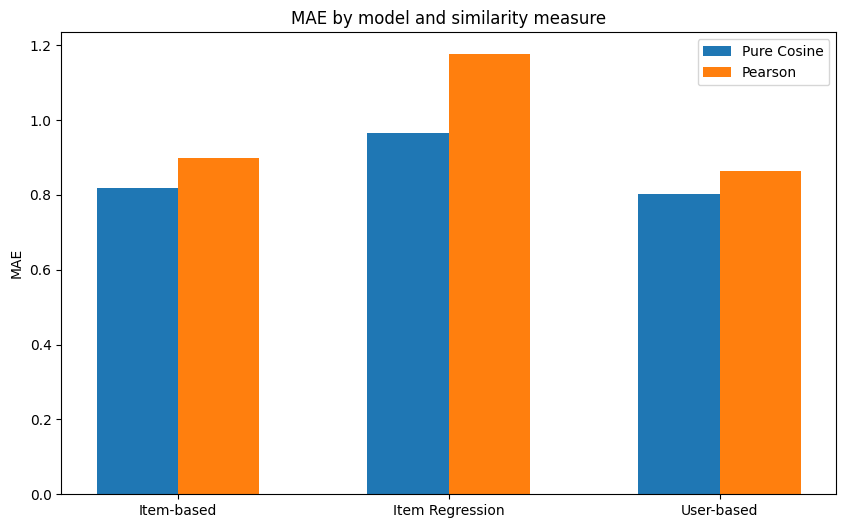

In [23]:
ib_MAEs = results_df.loc[(results_df['model'] == 'item_based') & (results_df['x'] == 0.8) & (results_df['neighborhood_size'] == 30)].sort_values(by='similarity_function')['MAE'].values[1:]
ibr_MAEs = results_df.loc[(results_df['model'] == 'item_regression') & (results_df['x'] == 0.8) & (results_df['neighborhood_size'] == 30)].sort_values(by='similarity_function')['MAE'].values[1:]
ub_MAEs = results_df.loc[(results_df['model'] == 'user_based') & (results_df['x'] == 0.8) & (results_df['neighborhood_size'] == 30)].sort_values(by='similarity_function')['MAE'].values[1:]

labels = ['Item-based', 'Item Regression', 'User-based']
pure_cosine = [ib_MAEs[1], ibr_MAEs[1], ub_MAEs[1]]
pearson = [ib_MAEs[0], ibr_MAEs[0], ub_MAEs[0]]

x = np.arange(len(labels))
width = 0.3 

fig_ex_1 = plt.figure(figsize=(10, 6))
plt.bar(x - width/2, pure_cosine, width, label='Pure Cosine')
plt.bar(x + width/2, pearson, width, label='Pearson')

plt.ylabel('MAE')
plt.title('MAE by model and similarity measure')
plt.xticks(x, labels)
plt.legend()


plt.show()


In [31]:
fig_ex_1.savefig('../figures/ex_1.png')

## 2.  Sensitivity of Training/Test Ratio

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7668\641603367.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r^-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xs, ub_MAEs_for_each_x, 'r^-', color='blue', label='usr-usr(pure_cosine)')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7668\641603367.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "c*-" (-> color='c'). The keyword argument will take precedence.
  plt.plot(xs, np_MAEs_for_each_x, 'c*-', color='green', label='non-per')


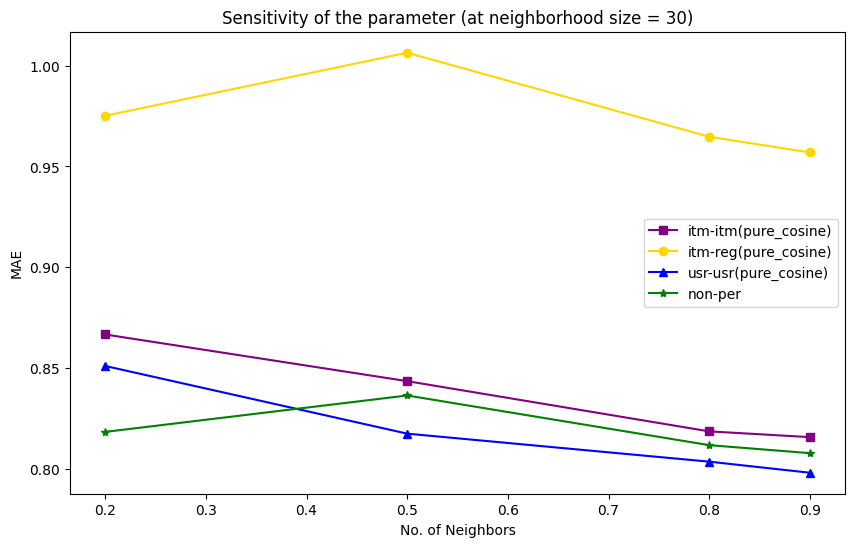

In [8]:
ib_MAEs_for_each_x = results_df.loc[(results_df['model'] == 'item_based') & (results_df['neighborhood_size'] == 30) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='x')['MAE'].values
ibr_MAEs_for_each_x = results_df.loc[(results_df['model'] == 'item_regression') & (results_df['neighborhood_size'] == 30) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='x')['MAE'].values
ub_MAEs_for_each_x = results_df.loc[(results_df['model'] == 'user_based') & (results_df['neighborhood_size'] == 30) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='x')['MAE'].values
np_MAEs_for_each_x = results_df.loc[(results_df['model'] == 'nonper') & (results_df['neighborhood_size'] == 30) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='x')['MAE'].values

xs = [0.2, 0.5, 0.8, 0.9]
fig_ex_2 = plt.figure(figsize=(10, 6))
plt.plot(xs, ib_MAEs_for_each_x, 's-', color='purple', label='itm-itm(pure_cosine)')
plt.plot(xs, ibr_MAEs_for_each_x, 'o-', color='gold', label='itm-reg(pure_cosine)')
plt.plot(xs, ub_MAEs_for_each_x, 'r^-', color='blue', label='usr-usr(pure_cosine)') 
plt.plot(xs, np_MAEs_for_each_x, 'c*-', color='green', label='non-per')  

plt.title('Sensitivity of the parameter (at neighborhood size = 30)')
plt.xlabel('No. of Neighbors')
plt.ylabel('MAE')
plt.legend()

In [9]:
fig_ex_2.savefig('../figures/ex_2.png')

## 3.  Experiments with neighborhood size

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2868\784611944.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r^-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(neighborhood_sizes, ub_MAEs_for_each_neighborhood_size, 'r^-', color='blue', label='usr-usr(pure_cosine)')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2868\784611944.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "c*-" (-> color='c'). The keyword argument will take precedence.
  plt.plot(neighborhood_sizes, np_MAEs_for_each_neighborhood_size, 'c*-', color='green', label='non-per')


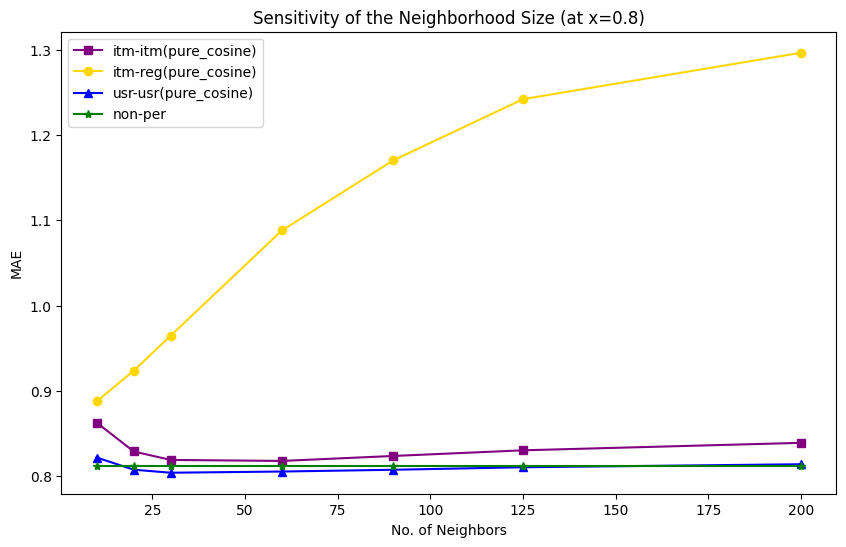

In [30]:
ib_MAEs_for_each_neighborhood_size = results_df.loc[(results_df['model'] == 'item_based') & (results_df['x'] == 0.8) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='neighborhood_size')['MAE'].values
ibr_MAEs_for_each_neighborhood_size = results_df.loc[(results_df['model'] == 'item_regression') & (results_df['x'] == 0.8) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='neighborhood_size')['MAE'].values
ub_MAEs_for_each_neighborhood_size = results_df.loc[(results_df['model'] == 'user_based') & (results_df['x'] == 0.8) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='neighborhood_size')['MAE'].values
np_MAEs_for_each_neighborhood_size = results_df.loc[(results_df['model'] == 'nonper') & (results_df['x'] == 0.8) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='neighborhood_size')['MAE'].values

neighborhood_sizes = [10, 20, 30, 60, 90, 125, 200]
fig_ex_3 = plt.figure(figsize=(10, 6))
plt.plot(neighborhood_sizes, ib_MAEs_for_each_neighborhood_size, 's-', color='purple', label='itm-itm(pure_cosine)')
plt.plot(neighborhood_sizes, ibr_MAEs_for_each_neighborhood_size, 'o-', color='gold', label='itm-reg(pure_cosine)')
plt.plot(neighborhood_sizes, ub_MAEs_for_each_neighborhood_size, 'r^-', color='blue', label='usr-usr(pure_cosine)')  
plt.plot(neighborhood_sizes, np_MAEs_for_each_neighborhood_size, 'c*-', color='green', label='non-per')  

plt.title('Sensitivity of the Neighborhood Size (at x=0.8)')
plt.xlabel('No. of Neighbors')
plt.ylabel('MAE')
plt.legend()



In [17]:
fig_ex_3.savefig('../figures/ex_3.png')